# ENV

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, Model
from xgboost import XGBRegressor 
import random
from scipy.stats import wasserstein_distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,accuracy_score,explained_variance_score
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from bayes_opt import BayesianOptimization
from sklearn.metrics import make_scorer
from copy import deepcopy


In [2]:
def set_global_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_global_seed(42)

# Data Loading

In [3]:
df = pd.read_excel("generated_data_1.xlsx", sheet_name="Sample Data")
df.describe()

,Fe,Cr,Ni,Mn,Al,Cu,Co,E_M-M,pH of zero charge of oxides_Aver,Gibbs free energy of oxide formation_Aver,...,Energy of ionization second_Aver,Oxidation state first_Aver,Valence electron number_Aver,Work function of oxides_Aver,Heat of adsorption of oxygen_Aver,band gap_Aver,Enthalpy of melting_Aver,dr,S,Epit
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,...,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.239551,0.207775,0.227775,0.045204,0.024498,0.044952,0.212944,80.979292,8.426775,-91.476936,...,1655.254571,1.984944,8.241702,5.123041,547.635500,2.966998,16.505142,0.023135,12.443882,174.125301
std,0.072769,0.067522,0.048042,0.080091,0.047947,0.075232,0.069119,3.836747,0.377207,47.583005,...,43.838339,0.107659,0.438001,0.129396,39.427638,0.320838,0.731285,0.024569,1.187749,275.003295
min,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,68.132667,7.454000,-238.730000,...,1595.200000,1.750000,7.200000,4.964250,435.920000,2.396000,14.740000,0.001685,9.133863,-585.000000
25%,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.200000,78.775062,8.314000,-108.984000,...,1638.000000,1.888889,7.943750,5.071889,519.236190,2.756000,16.040000,0.003153,11.525651,27.500000
50%,0.232558,0.222222,0.222222,0.000000,0.000000,0.000000,0.222222,81.701646,8.475000,-85.251538,...,1650.517300,2.000000,8.250000,5.122000,546.920000,2.950000,16.616279,0.022981,12.647715,90.000000
75%,0.250000,0.250000,0.250000,0.052551,0.027195,0.111111,0.250000,84.107983,8.533333,-59.615556,...,1673.555555,2.012545,8.555556,5.141860,568.336000,3.181818,17.073958,0.034548,13.249722,335.000000
max,0.400000,0.333333,0.400000,0.202801,0.200000,0.250000,0.333333,88.286000,9.300000,31.987500,...,1937.133333,2.400000,9.500000,6.190667,715.066667,3.960000,20.013333,0.184748,14.896688,860.000000


In [4]:
COMP_COLS = ['Fe','Cr','Ni','Mn','Al','Cu','Co']

# Comparison

## Downstream Eval

In [5]:
def train_and_evaluate_xgboost(X_train, y_train, X_test, y_test):
    if y_train.ndim == 2 and y_train.shape[1] == 1:
        y_train_flat = y_train.ravel()
    else:
        y_train_flat = y_train
    if y_test.ndim == 2 and y_test.shape[1] == 1:
        y_test_flat = y_test.ravel()
    else:
        y_test_flat = y_test

    model = XGBRegressor(
        n_estimators=200,        
        max_depth=3,             
        learning_rate=0.03,
        subsample=0.6,         
        colsample_bytree=0.6,  
        min_child_weight=10,     
        gamma=5.0,             
        reg_alpha=1.0,        
        reg_lambda=10.0,       
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train_flat)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test_flat, y_pred)
    rmse = mean_squared_error(y_test_flat, y_pred, squared=False)

    print(f"=== (XGBoost) ===")
    print(f"R^2  = {r2:.4f}")
    print(f"RMSE = {rmse:.4f}")
    return {"R2": r2, "RMSE": rmse}

In [6]:
from sklearn.model_selection import KFold

def train_and_evaluate_xgboost_cv(X, y, n_splits=5):
    if y.ndim == 2 and y.shape[1] == 1:
        y = y.ravel()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    r2_list = []
    rmse_list = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        
        model = XGBRegressor(
            n_estimators=600,        
            max_depth=4,            
            learning_rate=0.03,    
            subsample=0.8,          
            colsample_bytree=0.8,   
            min_child_weight=2,    
            gamma=0.0,              
            reg_alpha=0.0,         
            reg_lambda=1.0,        
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        r2 = r2_score(y_val, y_pred)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        r2_list.append(r2)
        rmse_list.append(rmse)

        print(f"[Fold {fold+1}] R2 = {r2:.4f}, RMSE = {rmse:.4f}")

    print("\n=== (XGBoost K-Fold CV) ===")
    print(f"Mean R²  = {np.mean(r2_list):.4f}  ± {np.std(r2_list):.4f}")
    print(f"Mean RMSE = {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")

    return {
        "R2_mean": np.mean(r2_list),
        "R2_std": np.std(r2_list),
        "RMSE_mean": np.mean(rmse_list),
        "RMSE_std": np.std(rmse_list)
    }


In [ ]:
from sklearn.ensemble import RandomForestRegressor

def train_and_evaluate_rf_cv(X, y, n_splits=5):
    if y.ndim == 2 and y.shape[1] == 1:
        y = y.ravel()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    r2_list = []
    rmse_list = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = RandomForestRegressor(
            n_estimators=800,
            max_depth=15,              
            min_samples_split=5,        
            min_samples_leaf=3,         
            max_features=0.5,           
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        r2 = r2_score(y_val, y_pred)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        r2_list.append(r2)
        rmse_list.append(rmse)

        print(f"[Fold {fold+1}] R2 = {r2:.4f}, RMSE = {rmse:.4f}")

    print("\n=== (Random Forest K-Fold CV) ===")
    print(f"Mean R²  = {np.mean(r2_list):.4f}  ± {np.std(r2_list):.4f}")
    print(f"Mean RMSE = {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")

    return {
        "R2_mean": np.mean(r2_list),
        "R2_std": np.std(r2_list),
        "RMSE_mean": np.mean(rmse_list),
        "RMSE_std": np.std(rmse_list)
    }


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
def train_and_evaluate_svr_cv(X, y, n_splits=5):
    if y.ndim == 2 and y.shape[1] == 1:
        y = y.ravel()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    r2_list = []
    rmse_list = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("svr", SVR(
                kernel="rbf",
                C=50.0,
                epsilon=0.05,
                gamma="scale" 
            ))
        ])

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        r2 = r2_score(y_val, y_pred)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        r2_list.append(r2)
        rmse_list.append(rmse)

        print(f"[Fold {fold+1}] R2 = {r2:.4f}, RMSE = {rmse:.4f}")

    print("\n=== (SVR K-Fold CV) ===")
    print(f"Mean R²  = {np.mean(r2_list):.4f}  ± {np.std(r2_list):.4f}")
    print(f"Mean RMSE = {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")

    return {
        "R2_mean": np.mean(r2_list),
        "R2_std": np.std(r2_list),
        "RMSE_mean": np.mean(rmse_list),
        "RMSE_std": np.std(rmse_list)
    }

In [9]:
class RobustNN(nn.Module):
    def __init__(self, input_dim):
        super(RobustNN, self).__init__()
        self.feature_weights = nn.Parameter(torch.ones(input_dim))  # 可学习特征权重
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x * self.feature_weights
        return self.net(x)

def loss_fn_with_l1(output, target, model, l1_lambda=0.01):
    mse_loss = nn.MSELoss()(output, target)
    l1_penalty = l1_lambda * torch.norm(model.feature_weights, p=1)
    return mse_loss + l1_penalty

def train_model(model, train_loader, val_loader, num_epochs=600, patience=80, l1_lambda=0.01, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            preds = model(batch_X).squeeze()
            loss = loss_fn_with_l1(preds, batch_y, model, l1_lambda)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_preds = model(val_X).squeeze()
                val_loss = loss_fn_with_l1(val_preds, val_y, model, l1_lambda)
                val_losses.append(val_loss.item())

        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)

        # print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                # print("Early stopping triggered!")
                break

    model.load_state_dict(best_model_state)

    # 可视化 loss 曲线
    # plt.plot(train_loss_history, label='Train Loss')
    # plt.plot(val_loss_history, label='Val Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title("Training and Validation Loss")
    # plt.grid(True)
    # plt.show()

    return model

def evaluate_model(model, test_loader, y_scaler):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch).squeeze()
            predictions.append(output.cpu().numpy())
            targets.append(y_batch.cpu().numpy())

    preds = np.concatenate(predictions)
    trues = np.concatenate(targets)

    preds_real = y_scaler.inverse_transform(preds.reshape(-1, 1)).ravel()
    trues_real = y_scaler.inverse_transform(trues.reshape(-1, 1)).ravel()

    mae = mean_absolute_error(trues_real, preds_real)
    mse = mean_squared_error(trues_real, preds_real)
    rmse = np.sqrt(mse)
    r2 = r2_score(trues_real, preds_real)


    # print("\n=== 测试集评估结果 ===")
    # print(f"MAE: {mae:.4f}")
    # print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")

    return preds_real, trues_real

In [10]:
def train_and_evaluate_robustnn_cv(X, y, n_splits=3,
                                   num_epochs=200, patience=40,
                                   l1_lambda=0.01, lr=1e-3, batch_size=32):
    if y.ndim == 2 and y.shape[1] == 1:
        y = y.ravel()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    r2_list = []
    rmse_list = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        X_scaler = StandardScaler()
        y_scaler = StandardScaler()

        X_train_scaled = X_scaler.fit_transform(X_train)
        X_val_scaled = X_scaler.transform(X_val)

        y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).ravel()

        X_train_tensor = torch.from_numpy(X_train_scaled.astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train_scaled.astype(np.float32))
        X_val_tensor = torch.from_numpy(X_val_scaled.astype(np.float32))
        y_val_tensor = torch.from_numpy(y_val_scaled.astype(np.float32))

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = RobustNN(input_dim=X.shape[1])
        model = train_model(model, train_loader, val_loader,
                            num_epochs=num_epochs,
                            patience=patience,
                            l1_lambda=l1_lambda,
                            lr=lr)

        model.eval()
        preds_list = []
        trues_list = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch).squeeze(-1)
                preds_list.append(outputs.cpu().numpy().reshape(-1))
                trues_list.append(y_batch.cpu().numpy().reshape(-1))

        preds_scaled = np.concatenate(preds_list)
        trues_scaled = np.concatenate(trues_list)

        preds_real = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
        trues_real = y_scaler.inverse_transform(trues_scaled.reshape(-1, 1)).ravel()

        rmse = mean_squared_error(trues_real, preds_real, squared=False)
        r2 = r2_score(trues_real, preds_real)

        r2_list.append(r2)
        rmse_list.append(rmse)

        print(f"[Fold {fold+1}] R2 = {r2:.4f}, RMSE = {rmse:.4f}")

    print("\n=== (RobustNN K-Fold CV) ===")
    print(f"Mean R²  = {np.mean(r2_list):.4f}  ± {np.std(r2_list):.4f}")
    print(f"Mean RMSE = {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")

    return {
        "R2_mean": np.mean(r2_list),
        "R2_std": np.std(r2_list),
        "RMSE_mean": np.mean(rmse_list),
        "RMSE_std": np.std(rmse_list)
    }


## Data Augmentation

### Interpolation

In [11]:
def interpolation_generate(df, n_new=500, seed=42):
    np.random.seed(seed)
    data = df.values.astype(np.float32)
    N, D = data.shape

    idx1 = np.random.randint(0, N, size=n_new)
    idx2 = np.random.randint(0, N, size=n_new)
    lambdas = np.random.rand(n_new, 1).astype(np.float32)

    new_data = lambdas * data[idx1] + (1.0 - lambdas) * data[idx2]
    new_df = pd.DataFrame(new_data, columns=df.columns)

    comps = new_df[COMP_COLS].values.astype(np.float32)
    comps = np.clip(comps, 0.0, None)
    sums = comps.sum(axis=1, keepdims=True)
    sums[sums == 0] = 1.0
    comps = comps / sums
    new_df.loc[:, COMP_COLS] = comps

    return new_df

### Random Noise

In [12]:
def random_noise_generate(df, n_new=500, noise_scale=0.02, seed=42):
    np.random.seed(seed)
    data = df.values.astype(np.float32)
    N, D = data.shape
    base_idx = np.random.randint(0, N, size=n_new)
    base = data[base_idx]

    std = data.std(axis=0, keepdims=True) + 1e-8
    noise = np.random.randn(n_new, D).astype(np.float32) * (noise_scale * std)
    new_data = base + noise
    new_df = pd.DataFrame(new_data, columns=df.columns)

    comps = new_df[COMP_COLS].values.astype(np.float32)
    comps = np.clip(comps, 0.0, None)
    sums = comps.sum(axis=1, keepdims=True)
    sums[sums == 0] = 1.0
    comps = comps / sums
    new_df.loc[:, COMP_COLS] = comps

    return new_df

### Vanilla GAN

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd


class GAN:
    def __init__(self, n_comp=7, seed=42):
        self.X = None
        self.generator = None
        self.discriminator = None
        self.gan = None
        self.gan_scaler = None
        self.n_comp = n_comp
        self.seed = seed

    def _set_seed(self):
        np.random.seed(self.seed)
        random.seed(self.seed)
        tf.random.set_seed(self.seed)

    def load_data(self, data):
        if isinstance(data, pd.DataFrame):
            self.X = data.values.astype(np.float32)
        else:
            self.X = np.asarray(data, dtype=np.float32)
        print(f"loaded, shape: {self.X.shape}")

    def build_generator(self, latent_dim=10, feature_dim=12):
        kernel_init = tf.keras.initializers.GlorotUniform(seed=self.seed)
        bias_init = tf.keras.initializers.Zeros()

        model = Sequential([
            Dense(16, input_dim=latent_dim, activation='relu',
                  kernel_initializer=kernel_init, bias_initializer=bias_init),
            Dense(feature_dim, activation='tanh',
                  kernel_initializer=kernel_init, bias_initializer=bias_init)
        ])
        return model

    def build_discriminator(self, feature_dim=12):
        kernel_init = tf.keras.initializers.GlorotUniform(seed=self.seed)
        bias_init = tf.keras.initializers.Zeros()

        model = Sequential([
            Dense(16, input_dim=feature_dim, activation='relu',
                  kernel_initializer=kernel_init, bias_initializer=bias_init),
            Dense(1, activation='sigmoid',
                  kernel_initializer=kernel_init, bias_initializer=bias_init)
        ])
        return model

    def train_gan(self, epochs=500, batch_size=16, latent_dim=10):
        self._set_seed()

        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_scaled = scaler.fit_transform(self.X)
        self.gan_scaler = scaler

        feature_dim = X_scaled.shape[1]

        self.generator = self.build_generator(latent_dim, feature_dim)
        self.discriminator = self.build_discriminator(feature_dim)

        self.discriminator.trainable = True
        self.discriminator.compile(optimizer='adam', loss='binary_crossentropy')

        self.discriminator.trainable = False
        gan_input = Input(shape=(latent_dim,))
        gan_output = self.discriminator(self.generator(gan_input))
        self.gan = Model(gan_input, gan_output)
        self.gan.compile(optimizer='adam', loss='binary_crossentropy')

        for epoch in range(epochs):
            # ---- 训练判别器 ----
            self.discriminator.trainable = True

            idx = np.random.randint(0, X_scaled.shape[0], batch_size)
            real_data = X_scaled[idx]
            real_labels = np.ones((batch_size, 1), dtype=np.float32)

            noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype(np.float32)
            fake_data = self.generator.predict(noise, verbose=0)
            fake_labels = np.zeros((batch_size, 1), dtype=np.float32)

            self.discriminator.train_on_batch(real_data, real_labels)
            self.discriminator.train_on_batch(fake_data, fake_labels)

            # ---- 训练生成器 ----
            self.discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype(np.float32)
            valid_labels = np.ones((batch_size, 1), dtype=np.float32)
            self.gan.train_on_batch(noise, valid_labels)

            # 如果想看训练过程，可以解开：
            # if (epoch + 1) % 100 == 0:
            #     print(f"Epoch {epoch+1}/{epochs}")

        # print("GAN training done!")

    def generate_samples(self, num_samples=500, latent_dim=10):
        self._set_seed()

        noise = np.random.normal(0, 1, (num_samples, latent_dim)).astype(np.float32)
        generated_data = self.generator.predict(noise, verbose=0)
        generated_data = self.gan_scaler.inverse_transform(generated_data)

        elements = generated_data[:, :self.n_comp]
        others = generated_data[:, self.n_comp:]
        elements = np.clip(elements, 0.0, None)
        sums = elements.sum(axis=1, keepdims=True)
        sums[sums == 0] = 1.0
        elements = elements / sums

        combined_samples = np.concatenate([elements, others], axis=1)
        return combined_samples

In [14]:
def gan_generate(df, n_new=500, latent_dim=10, epochs=500, batch_size=32, seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    gan = GAN(n_comp=len(COMP_COLS))
    gan.load_data(df)  
    gan.train_gan(epochs=epochs, batch_size=batch_size, latent_dim=latent_dim)
    new = gan.generate_samples(num_samples=n_new, latent_dim=latent_dim)
    new_df = pd.DataFrame(new, columns=df.columns)
    return new_df

### WGAN-GP

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler

class WGAN_GP:
    def __init__(self, comp_dim=7, gp_lambda=2.0, latent_dim=16,
                 g_hidden=128, d_hidden=64, n_critic=3,
                 lr=1e-4, beta_1=0.0, beta_2=0.9, seed=42):
        tf.random.set_seed(seed)
        np.random.seed(seed)

        self.comp_dim   = comp_dim
        self.other_dim  = None
        self.scaler_other = None

        self.latent_dim = latent_dim
        self.gp_lambda  = gp_lambda
        self.n_critic   = n_critic

        self.g_optimizer = tf.keras.optimizers.Adam(lr, beta_1, beta_2)
        self.d_optimizer = tf.keras.optimizers.Adam(lr, beta_1, beta_2)

        self.g_hidden = g_hidden
        self.d_hidden = d_hidden

        self.generator = None
        self.critic    = None

        self.X_comp = None
        self.X_other = None
        self.train_data = None

    def load_data(self, data):
        X = data.values if isinstance(data, pd.DataFrame) else data
        assert X.ndim == 2 and X.shape[1] > self.comp_dim, "数据列数必须 > comp_dim"

        comp  = X[:, :self.comp_dim].astype(np.float32)
        other = X[:, self.comp_dim:].astype(np.float32)
        self.other_dim = other.shape[1]

        comp = np.clip(comp, 0.0, None)
        s = comp.sum(axis=1, keepdims=True)
        s[s == 0] = 1.0
        comp = comp / s
        self.scaler_other = MinMaxScaler(feature_range=(-1, 1))
        other_scaled = self.scaler_other.fit_transform(other).astype(np.float32)

        self.train_data = np.concatenate([comp, other_scaled], axis=1).astype(np.float32)
        self.X_comp  = comp
        self.X_other = other
        print(f"[load_data] comp_dim={self.comp_dim}, other_dim={self.other_dim}, n={X.shape[0]}")

    def build_generator(self):
        z = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(self.g_hidden, activation='relu')(z)
        x = layers.Dense(self.g_hidden, activation='relu')(x)

        comp_logits = layers.Dense(self.comp_dim)(x)
        comp_softmax = layers.Activation('softmax', name='comp_softmax')(comp_logits)
        other_tanh = layers.Dense(self.other_dim, activation='tanh', name='other_tanh')(x)

        out = layers.Concatenate(name='gen_out')([comp_softmax, other_tanh])
        self.generator = Model(z, out, name='Generator')
        return self.generator

    def build_critic(self):
        inp = layers.Input(shape=(self.comp_dim + self.other_dim,))
        x = layers.Dense(self.d_hidden, activation='relu')(inp)
        x = layers.Dense(self.d_hidden, activation='relu')(x)
        out = layers.Dense(1, activation=None)(x)   
        self.critic = Model(inp, out, name='Critic')
        return self.critic

    @staticmethod
    def wasserstein_loss(real_scores, fake_scores):
        return tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores)

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        epsilon = tf.random.uniform([batch_size, 1], 0.0, 1.0)
        epsilon = tf.broadcast_to(epsilon, tf.shape(real_samples))
        x_hat = epsilon * real_samples + (1 - epsilon) * fake_samples
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(x_hat)
            d_hat = self.critic(x_hat, training=True)
        grads = gp_tape.gradient(d_hat, [x_hat])[0]
        grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
        gp = tf.reduce_mean(tf.square(grad_norm - 1.0))
        return gp

    @tf.function
    def train_critic_step(self, real_batch):
        z = tf.random.normal([tf.shape(real_batch)[0], self.latent_dim])

        with tf.GradientTape() as tape:
            fake_batch = self.generator(z, training=True)
            d_real = self.critic(real_batch, training=True)
            d_fake = self.critic(fake_batch, training=True)

            w_loss = self.wasserstein_loss(d_real, d_fake)
            gp = self.gradient_penalty(real_batch, fake_batch)
            d_loss = w_loss + self.gp_lambda * gp

        grads = tape.gradient(d_loss, self.critic.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
        return d_loss, w_loss, gp

    @tf.function
    def train_generator_step(self, batch_size):
        z = tf.random.normal([batch_size, self.latent_dim])
        with tf.GradientTape() as tape:
            fake_batch = self.generator(z, training=True)
            d_fake = self.critic(fake_batch, training=True)
            g_loss = -tf.reduce_mean(d_fake)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        return g_loss

    def train(self, epochs=2000, batch_size=128, log_every=100):
        assert self.train_data is not None, "请先调用 load_data()"

        self.build_generator()
        self.build_critic()

        ds = tf.data.Dataset.from_tensor_slices(self.train_data)\
                            .shuffle(buffer_size=len(self.train_data))\
                            .batch(batch_size, drop_remainder=False)\
                            .prefetch(tf.data.AUTOTUNE)

        step = 0
        for epoch in range(1, epochs + 1):
            for real_batch in ds:
                for _ in range(self.n_critic):
                    d_loss, w_loss, gp = self.train_critic_step(real_batch)
                g_loss = self.train_generator_step(tf.shape(real_batch)[0])

                step += 1

            # if epoch % log_every == 0 or epoch == 1:
                # print(f"Epoch {epoch}/{epochs} | "
                #       f"D: {d_loss.numpy():.4f} (W:{w_loss.numpy():.4f}, GP:{gp.numpy():.4f}) "
                #       f"| G: {g_loss.numpy():.4f}")

        # print("[train] done.")

    def generate(self, num_samples=200, return_df=False, columns=None):
        """
        输出 = [comp_softmax, inverse_transform(other_tanh)]
        """
        z = tf.random.normal([num_samples, self.latent_dim])
        gen = self.generator(z, training=False).numpy()

        gen_comp = gen[:, :self.comp_dim]              
        gen_other_scaled = gen[:, self.comp_dim:]
        gen_other = self.scaler_other.inverse_transform(gen_other_scaled)

        out = np.concatenate([gen_comp, gen_other], axis=1)

        if return_df:
            if columns is None:
                columns = [f"elem_{i+1}" for i in range(self.comp_dim)] + \
                          [f"feat_{i+1}" for i in range(self.other_dim)]
            return pd.DataFrame(out, columns=columns)
        return out


In [16]:
def wgan_generate(df, n_new=500, epochs=1500, batch_size=32, log_every=100, seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    comp_dim = len(COMP_COLS)
    wgan = WGAN_GP(comp_dim=comp_dim)
    wgan.load_data(df)
    wgan.train(epochs=epochs, batch_size=batch_size, log_every=log_every)
    new_df = wgan.generate(num_samples=n_new, return_df=True, columns=df.columns)
    return new_df

## Comparison Results

In [17]:
TARGET_COL = 'Epit'
FEATURE_COLS = df.drop(TARGET_COL, axis=1).columns.tolist()

In [18]:
X_base = df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_base = df[TARGET_COL].values.astype(np.float32)

print("=== No augmentation (baseline, XGBoost CV) ===")
results = []

res_base = train_and_evaluate_xgboost_cv(X_base, y_base)
res_base["Method"] = "No augmentation"
results.append(res_base)

# ============================================
print("\n=== Interpolation (500 new samples, CV) ===")
interp_new_df = interpolation_generate(df, n_new=500)
interp_df = pd.concat([df, interp_new_df], axis=0, ignore_index=True)

X_interp = interp_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_interp = interp_df[TARGET_COL].values.astype(np.float32)

res_interp = train_and_evaluate_xgboost_cv(X_interp, y_interp)
res_interp["Method"] = "Interpolation +500"
results.append(res_interp)

# ============================================
print("\n=== Random Noise (500 new samples, CV) ===")
noise_new_df = random_noise_generate(df, n_new=500, noise_scale=0.05)
noise_df = pd.concat([df, noise_new_df], axis=0, ignore_index=True)

X_noise = noise_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_noise = noise_df[TARGET_COL].values.astype(np.float32)

res_noise = train_and_evaluate_xgboost_cv(X_noise, y_noise)
res_noise["Method"] = "Random noise +500"
results.append(res_noise)

# ============================================
print("\n=== Vanilla GAN (500 new samples, CV) ===")
gan_new_df = gan_generate(df, n_new=500,
                          latent_dim=10, epochs=500, batch_size=64)
gan_df = pd.concat([df, gan_new_df], axis=0, ignore_index=True)

X_gan = gan_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_gan = gan_df[TARGET_COL].values.astype(np.float32)

res_gan = train_and_evaluate_xgboost_cv(X_gan, y_gan)
res_gan["Method"] = "Vanilla GAN +500"
results.append(res_gan)

# ============================================
print("\n=== WGAN-GP (500 new samples, CV) ===")
wgan_new_df = wgan_generate(df, n_new=500,
                            epochs=4000, batch_size=64, log_every=100)
wgan_df = pd.concat([df, wgan_new_df], axis=0, ignore_index=True)

X_wgan = wgan_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_wgan = wgan_df[TARGET_COL].values.astype(np.float32)

res_wgan = train_and_evaluate_xgboost_cv(X_wgan, y_wgan)
res_wgan["Method"] = "WGAN-GP +500"
results.append(res_wgan)


# ============================================
summary = pd.DataFrame(results)[
    ["Method", "R2_mean", "R2_std", "RMSE_mean", "RMSE_std"]
]

print("\n=== Summary (XGBoost CV, all methods) ===")
print(summary.to_string(index=False))


=== No augmentation (baseline, XGBoost CV) ===
[Fold 1] R2 = 0.0826, RMSE = 245.2277
[Fold 2] R2 = -0.1808, RMSE = 267.7496
[Fold 3] R2 = 0.0291, RMSE = 211.9449
[Fold 4] R2 = 0.5269, RMSE = 189.6188
[Fold 5] R2 = 0.5477, RMSE = 226.3058

=== (XGBoost K-Fold CV) ===
Mean R²  = 0.2011  ± 0.2884
Mean RMSE = 228.1694 ± 26.8717

=== Interpolation (500 new samples, CV) ===
[Fold 1] R2 = 0.5364, RMSE = 166.3092
[Fold 2] R2 = 0.5864, RMSE = 136.9481
[Fold 3] R2 = 0.5003, RMSE = 158.8709
[Fold 4] R2 = 0.4997, RMSE = 156.4419
[Fold 5] R2 = 0.5788, RMSE = 150.2697

=== (XGBoost K-Fold CV) ===
Mean R²  = 0.5403  ± 0.0371
Mean RMSE = 153.7680 ± 9.8551

=== Random Noise (500 new samples, CV) ===
[Fold 1] R2 = 0.6309, RMSE = 161.5833
[Fold 2] R2 = 0.5709, RMSE = 158.3400
[Fold 3] R2 = 0.6386, RMSE = 163.9255
[Fold 4] R2 = 0.5468, RMSE = 164.1522
[Fold 5] R2 = 0.6422, RMSE = 178.7812

=== (XGBoost K-Fold CV) ===
Mean R²  = 0.6059  ± 0.0393
Mean RMSE = 165.3564 ± 7.0312

=== Vanilla GAN (500 new sampl

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[Fold 1] R2 = 0.8421, RMSE = 139.3593
[Fold 2] R2 = 0.8333, RMSE = 129.1639
[Fold 3] R2 = 0.8504, RMSE = 129.1342
[Fold 4] R2 = 0.9322, RMSE = 89.8340
[Fold 5] R2 = 0.8721, RMSE = 117.9283

=== (XGBoost K-Fold CV) ===
Mean R²  = 0.8660  ± 0.0355
Mean RMSE = 121.0839 ± 17.0329

=== WGAN-GP (500 new samples, CV) ===
[load_data] comp_dim=7, other_dim=19, n=83


2025-11-27 16:07:09.770690: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 16:07:09.777275: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 16:07:09.784737: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 16:07:09.801056: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 16:07:09.829252: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 16:07:09.886729: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 16:07:10.019334: I tensorflow/core/framework/local_rendezvous.cc:407] L

[Fold 1] R2 = 0.6821, RMSE = 164.2428
[Fold 2] R2 = 0.7742, RMSE = 144.3400
[Fold 3] R2 = 0.7179, RMSE = 143.2177
[Fold 4] R2 = 0.7626, RMSE = 123.6765
[Fold 5] R2 = 0.6411, RMSE = 162.7955

=== (XGBoost K-Fold CV) ===
Mean R²  = 0.7156  ± 0.0496
Mean RMSE = 147.6545 ± 14.8999

=== Summary (XGBoost CV, all methods) ===
            Method  R2_mean   R2_std  RMSE_mean  RMSE_std
   No augmentation 0.201092 0.288376 228.169357 26.871689
Interpolation +500 0.540320 0.037076 153.767975  9.855134
 Random noise +500 0.605898 0.039329 165.356415  7.031185
  Vanilla GAN +500 0.866018 0.035519 121.083939 17.032909
      WGAN-GP +500 0.715572 0.049624 147.654495 14.899925


In [19]:
X_base = df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_base = df[TARGET_COL].values.astype(np.float32)

print("=== No augmentation (baseline, RF CV) ===")
results = []

res_base = train_and_evaluate_rf_cv(X_base, y_base)
res_base["Method"] = "No augmentation"
results.append(res_base)

print("\n=== Interpolation (500 new samples, RF CV) ===")
interp_new_df = interpolation_generate(df, n_new=500)
interp_df = pd.concat([df, interp_new_df], axis=0, ignore_index=True)

X_interp = interp_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_interp = interp_df[TARGET_COL].values.astype(np.float32)

res_interp = train_and_evaluate_rf_cv(X_interp, y_interp)
res_interp["Method"] = "Interpolation +500"
results.append(res_interp)

print("\n=== Random Noise (500 new samples, RF CV) ===")
noise_new_df = random_noise_generate(df, n_new=500, noise_scale=0.1)
noise_df = pd.concat([df, noise_new_df], axis=0, ignore_index=True)

X_noise = noise_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_noise = noise_df[TARGET_COL].values.astype(np.float32)

res_noise = train_and_evaluate_rf_cv(X_noise, y_noise)
res_noise["Method"] = "Random noise +500"
results.append(res_noise)

print("\n=== Vanilla GAN (500 new samples, RF CV) ===")
gan_new_df = gan_generate(df, n_new=500, latent_dim=10, epochs=500, batch_size=64)
gan_df = pd.concat([df, gan_new_df], axis=0, ignore_index=True)

X_gan = gan_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_gan = gan_df[TARGET_COL].values.astype(np.float32)

res_gan = train_and_evaluate_rf_cv(X_gan, y_gan)
res_gan["Method"] = "Vanilla GAN +500"
results.append(res_gan)

print("\n=== WGAN-GP (500 new samples, RF CV) ===")
wgan_new_df = wgan_generate(df, n_new=500, epochs=4000, batch_size=32, log_every=100)
wgan_df = pd.concat([df, wgan_new_df], axis=0, ignore_index=True)

X_wgan = wgan_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_wgan = wgan_df[TARGET_COL].values.astype(np.float32)

res_wgan = train_and_evaluate_rf_cv(X_wgan, y_wgan)
res_wgan["Method"] = "WGAN-GP +500"
results.append(res_wgan)

summary = pd.DataFrame(results)[["Method", "R2_mean", "R2_std", "RMSE_mean", "RMSE_std"]]

print("\n=== Summary (RF CV, all methods) ===")
print(summary.to_string(index=False))


=== No augmentation (baseline, RF CV) ===
[Fold 1] R2 = 0.2007, RMSE = 228.8924
[Fold 2] R2 = 0.0132, RMSE = 244.7713
[Fold 3] R2 = 0.2947, RMSE = 180.6446
[Fold 4] R2 = 0.5008, RMSE = 194.7789
[Fold 5] R2 = 0.4161, RMSE = 257.1388

=== (Random Forest K-Fold CV) ===
Mean R²  = 0.2851  ± 0.1702
Mean RMSE = 221.2452 ± 29.1519

=== Interpolation (500 new samples, RF CV) ===
[Fold 1] R2 = 0.5677, RMSE = 160.5930
[Fold 2] R2 = 0.5823, RMSE = 137.6250
[Fold 3] R2 = 0.5337, RMSE = 153.4705
[Fold 4] R2 = 0.5362, RMSE = 150.6256
[Fold 5] R2 = 0.6018, RMSE = 146.1063

=== (Random Forest K-Fold CV) ===
Mean R²  = 0.5643  ± 0.0263
Mean RMSE = 149.6841 ± 7.6479

=== Random Noise (500 new samples, RF CV) ===
[Fold 1] R2 = 0.6094, RMSE = 165.3659
[Fold 2] R2 = 0.5577, RMSE = 161.9724
[Fold 3] R2 = 0.6586, RMSE = 159.9676
[Fold 4] R2 = 0.5735, RMSE = 160.5797
[Fold 5] R2 = 0.6861, RMSE = 167.2102

=== (Random Forest K-Fold CV) ===
Mean R²  = 0.6171  ± 0.0489
Mean RMSE = 163.0192 ± 2.8082

=== Vanilla 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[Fold 1] R2 = 0.8025, RMSE = 155.8555
[Fold 2] R2 = 0.7875, RMSE = 145.8292
[Fold 3] R2 = 0.8064, RMSE = 146.8779
[Fold 4] R2 = 0.8878, RMSE = 115.5816
[Fold 5] R2 = 0.8024, RMSE = 146.5755

=== (Random Forest K-Fold CV) ===
Mean R²  = 0.8173  ± 0.0358
Mean RMSE = 142.1439 ± 13.7782

=== WGAN-GP (500 new samples, RF CV) ===
[load_data] comp_dim=7, other_dim=19, n=83


2025-11-27 16:07:57.919267: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Fold 1] R2 = 0.7563, RMSE = 136.7298
[Fold 2] R2 = 0.7298, RMSE = 151.7577
[Fold 3] R2 = 0.7307, RMSE = 142.1593
[Fold 4] R2 = 0.7795, RMSE = 126.3867
[Fold 5] R2 = 0.6312, RMSE = 172.0286

=== (Random Forest K-Fold CV) ===
Mean R²  = 0.7255  ± 0.0506
Mean RMSE = 145.8124 ± 15.4650

=== Summary (RF CV, all methods) ===
            Method  R2_mean   R2_std  RMSE_mean  RMSE_std
   No augmentation 0.285091 0.170209 221.245192 29.151944
Interpolation +500 0.564349 0.026338 149.684089  7.647864
 Random noise +500 0.617070 0.048936 163.019170  2.808222
  Vanilla GAN +500 0.817331 0.035832 142.143930 13.778229
      WGAN-GP +500 0.725510 0.050588 145.812427 15.465014


In [20]:
X_base = df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_base = df[TARGET_COL].values.astype(np.float32)

print("=== No augmentation (baseline, SVR CV) ===")
results = []

res_base = train_and_evaluate_svr_cv(X_base, y_base)
res_base["Method"] = "No augmentation"
results.append(res_base)

print("\n=== Interpolation (500 new samples, SVR CV) ===")
interp_new_df = interpolation_generate(df, n_new=500)
interp_df = pd.concat([df, interp_new_df], axis=0, ignore_index=True)

X_interp = interp_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_interp = interp_df[TARGET_COL].values.astype(np.float32)

res_interp = train_and_evaluate_svr_cv(X_interp, y_interp)
res_interp["Method"] = "Interpolation +500"
results.append(res_interp)

print("\n=== Random Noise (500 new samples, SVR CV) ===")
noise_new_df = random_noise_generate(df, n_new=500, noise_scale=0.1)
noise_df = pd.concat([df, noise_new_df], axis=0, ignore_index=True)

X_noise = noise_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_noise = noise_df[TARGET_COL].values.astype(np.float32)

res_noise = train_and_evaluate_svr_cv(X_noise, y_noise)
res_noise["Method"] = "Random noise +500"
results.append(res_noise)

print("\n=== Vanilla GAN (500 new samples, SVR CV) ===")
gan_new_df = gan_generate(df, n_new=500, latent_dim=10, epochs=500, batch_size=64)
gan_df = pd.concat([df, gan_new_df], axis=0, ignore_index=True)

X_gan = gan_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_gan = gan_df[TARGET_COL].values.astype(np.float32)

res_gan = train_and_evaluate_svr_cv(X_gan, y_gan)
res_gan["Method"] = "Vanilla GAN +500"
results.append(res_gan)

print("\n=== WGAN-GP (500 new samples, SVR CV) ===")
wgan_new_df = wgan_generate(df, n_new=500, epochs=4000, batch_size=32, log_every=100)
wgan_df = pd.concat([df, wgan_new_df], axis=0, ignore_index=True)

X_wgan = wgan_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_wgan = wgan_df[TARGET_COL].values.astype(np.float32)

res_wgan = train_and_evaluate_svr_cv(X_wgan, y_wgan)
res_wgan["Method"] = "WGAN-GP +500"
results.append(res_wgan)

summary = pd.DataFrame(results)[["Method", "R2_mean", "R2_std", "RMSE_mean", "RMSE_std"]]

print("\n=== Summary (SVR CV, all methods) ===")
print(summary.to_string(index=False))


=== No augmentation (baseline, SVR CV) ===
[Fold 1] R2 = 0.2507, RMSE = 221.6169
[Fold 2] R2 = 0.1023, RMSE = 233.4522
[Fold 3] R2 = 0.4989, RMSE = 152.2665
[Fold 4] R2 = 0.2338, RMSE = 241.3253
[Fold 5] R2 = 0.1781, RMSE = 305.0562

=== (SVR K-Fold CV) ===
Mean R²  = 0.2528  ± 0.1335
Mean RMSE = 230.7434 ± 48.7517

=== Interpolation (500 new samples, SVR CV) ===
[Fold 1] R2 = 0.4741, RMSE = 177.1318
[Fold 2] R2 = 0.5176, RMSE = 147.9091
[Fold 3] R2 = 0.5275, RMSE = 154.4863
[Fold 4] R2 = 0.5500, RMSE = 148.3720
[Fold 5] R2 = 0.5406, RMSE = 156.9386

=== (SVR K-Fold CV) ===
Mean R²  = 0.5219  ± 0.0264
Mean RMSE = 156.9676 ± 10.6648

=== Random Noise (500 new samples, SVR CV) ===
[Fold 1] R2 = 0.5378, RMSE = 179.8807
[Fold 2] R2 = 0.5635, RMSE = 160.9061
[Fold 3] R2 = 0.6096, RMSE = 171.0533
[Fold 4] R2 = 0.6048, RMSE = 154.5687
[Fold 5] R2 = 0.6238, RMSE = 183.0541

=== (SVR K-Fold CV) ===
Mean R²  = 0.5879  ± 0.0321
Mean RMSE = 169.8926 ± 10.8620

=== Vanilla GAN (500 new samples, SVR

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[Fold 1] R2 = 0.7884, RMSE = 161.3288
[Fold 2] R2 = 0.8367, RMSE = 127.8359
[Fold 3] R2 = 0.8675, RMSE = 121.5218
[Fold 4] R2 = 0.9060, RMSE = 105.7850
[Fold 5] R2 = 0.8027, RMSE = 146.4482

=== (SVR K-Fold CV) ===
Mean R²  = 0.8403  ± 0.0428
Mean RMSE = 132.5839 ± 19.3988

=== WGAN-GP (500 new samples, SVR CV) ===
[load_data] comp_dim=7, other_dim=19, n=83


2025-11-27 16:08:45.662696: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Fold 1] R2 = 0.7096, RMSE = 149.2496
[Fold 2] R2 = 0.6316, RMSE = 177.2098
[Fold 3] R2 = 0.6941, RMSE = 151.5060
[Fold 4] R2 = 0.7472, RMSE = 135.3190
[Fold 5] R2 = 0.5585, RMSE = 188.2348

=== (SVR K-Fold CV) ===
Mean R²  = 0.6682  ± 0.0663
Mean RMSE = 160.3038 ± 19.4411

=== Summary (SVR CV, all methods) ===
            Method  R2_mean   R2_std  RMSE_mean  RMSE_std
   No augmentation 0.252765 0.133521 230.743425 48.751651
Interpolation +500 0.521943 0.026359 156.967595 10.664836
 Random noise +500 0.587931 0.032099 169.892575 10.861976
  Vanilla GAN +500 0.840274 0.042834 132.583949 19.398849
      WGAN-GP +500 0.668210 0.066349 160.303835 19.441143


In [21]:
X_base = df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_base = df[TARGET_COL].values.astype(np.float32)

print("=== No augmentation (baseline, MLP CV) ===")
results = []

res_base = train_and_evaluate_robustnn_cv(X_base, y_base)
res_base["Method"] = "No augmentation"
results.append(res_base)

print("\n=== Interpolation (500 new samples, MLP CV) ===")
interp_new_df = interpolation_generate(df, n_new=500)
interp_df = pd.concat([df, interp_new_df], axis=0, ignore_index=True)

X_interp = interp_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_interp = interp_df[TARGET_COL].values.astype(np.float32)

res_interp = train_and_evaluate_robustnn_cv(X_interp, y_interp)
res_interp["Method"] = "Interpolation +500"
results.append(res_interp)

print("\n=== Random Noise (500 new samples, MLP CV) ===")
noise_new_df = random_noise_generate(df, n_new=500, noise_scale=0.1)
noise_df = pd.concat([df, noise_new_df], axis=0, ignore_index=True)

X_noise = noise_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_noise = noise_df[TARGET_COL].values.astype(np.float32)

res_noise = train_and_evaluate_robustnn_cv(X_noise, y_noise)
res_noise["Method"] = "Random noise +500"
results.append(res_noise)

print("\n=== Vanilla GAN (500 new samples, MLP CV) ===")
gan_new_df = gan_generate(df, n_new=500, latent_dim=10, epochs=500, batch_size=64)
gan_df = pd.concat([df, gan_new_df], axis=0, ignore_index=True)

X_gan = gan_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_gan = gan_df[TARGET_COL].values.astype(np.float32)

res_gan = train_and_evaluate_robustnn_cv(X_gan, y_gan)
res_gan["Method"] = "Vanilla GAN +500"
results.append(res_gan)

print("\n=== WGAN-GP (500 new samples, MLP CV) ===")
wgan_new_df = wgan_generate(df, n_new=500, epochs=4000, batch_size=64, log_every=100)
wgan_df = pd.concat([df, wgan_new_df], axis=0, ignore_index=True)

X_wgan = wgan_df.drop(TARGET_COL, axis=1).values.astype(np.float32)
y_wgan = wgan_df[TARGET_COL].values.astype(np.float32)

res_wgan = train_and_evaluate_robustnn_cv(X_wgan, y_wgan)
res_wgan["Method"] = "WGAN-GP +500"
results.append(res_wgan)

summary = pd.DataFrame(results)[["Method", "R2_mean", "R2_std", "RMSE_mean", "RMSE_std"]]

print("\n=== Summary (MLP CV, all methods) ===")
print(summary.to_string(index=False))


=== No augmentation (baseline, MLP CV) ===


[Fold 1] R2 = -0.1950, RMSE = 251.5120
[Fold 2] R2 = 0.1348, RMSE = 247.1765
[Fold 3] R2 = 0.3302, RMSE = 254.9252

=== (RobustNN K-Fold CV) ===
Mean R²  = 0.0900  ± 0.2168
Mean RMSE = 251.2046 ± 3.1709

=== Interpolation (500 new samples, MLP CV) ===
[Fold 1] R2 = 0.5806, RMSE = 155.1977
[Fold 2] R2 = 0.5021, RMSE = 146.7034
[Fold 3] R2 = 0.6272, RMSE = 142.3951

=== (RobustNN K-Fold CV) ===
Mean R²  = 0.5700  ± 0.0516
Mean RMSE = 148.0987 ± 5.3190

=== Random Noise (500 new samples, MLP CV) ===
[Fold 1] R2 = 0.6259, RMSE = 164.1550
[Fold 2] R2 = 0.5595, RMSE = 163.3799
[Fold 3] R2 = 0.7139, RMSE = 151.3936

=== (RobustNN K-Fold CV) ===
Mean R²  = 0.6331  ± 0.0633
Mean RMSE = 159.6428 ± 5.8417

=== Vanilla GAN (500 new samples, MLP CV) ===
loaded, shape: (83, 26)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[Fold 1] R2 = 0.8994, RMSE = 110.7848
[Fold 2] R2 = 0.9076, RMSE = 97.9499
[Fold 3] R2 = 0.9278, RMSE = 90.8786

=== (RobustNN K-Fold CV) ===
Mean R²  = 0.9116  ± 0.0120
Mean RMSE = 99.8711 ± 8.2394

=== WGAN-GP (500 new samples, MLP CV) ===
[load_data] comp_dim=7, other_dim=19, n=83
[Fold 1] R2 = 0.7675, RMSE = 138.1787
[Fold 2] R2 = 0.7871, RMSE = 131.5355
[Fold 3] R2 = 0.7446, RMSE = 134.6933

=== (RobustNN K-Fold CV) ===
Mean R²  = 0.7664  ± 0.0174
Mean RMSE = 134.8025 ± 2.7132

=== Summary (MLP CV, all methods) ===
            Method  R2_mean   R2_std  RMSE_mean  RMSE_std
   No augmentation 0.090009 0.216779 251.204575  3.170879
Interpolation +500 0.569967 0.051623 148.098709  5.318976
 Random noise +500 0.633096 0.063268 159.642838  5.841671
  Vanilla GAN +500 0.911583 0.011964  99.871101  8.239429
      WGAN-GP +500 0.766410 0.017379 134.802521  2.713151


## 分布性验证

In [ ]:
def compare_target_distribution_four(y_real,
                                     y_interp,
                                     y_noise,
                                     y_gan,
                                     y_wgan,
                                     nbins=10):

    y_real  = y_real.reshape(-1)
    y_interp = y_interp.reshape(-1)
    y_noise = y_noise.reshape(-1)
    y_gan   = y_gan.reshape(-1)
    y_wgan  = y_wgan.reshape(-1)

    plt.rcParams.update({
        "font.family": "Times New Roman",
        "axes.linewidth": 1.2
    })

    fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
    hist_range = (float(y_real.min()), float(y_real.max()))
    bins = np.linspace(hist_range[0], hist_range[1], nbins + 1)

    bin_width = bins[1] - bins[0]
    counts, _ = np.histogram(y_real, bins=bins)
    ax.bar(bins[:-1], counts / len(y_real) * 100,
           width=bin_width, align='edge',
           color="black", alpha=0.75,
           edgecolor="black", linewidth=0.9,
           label="Real")

    counts, _ = np.histogram(y_gan, bins=bins)
    ax.bar(bins[:-1], counts / len(y_gan) * 100,
           width=bin_width, align='edge',
           color="#004C99", alpha=0.45,    
           edgecolor=None,
           label="Vanilla GAN")

    counts, _ = np.histogram(y_wgan, bins=bins)
    ax.bar(bins[:-1], counts / len(y_wgan) * 100,
           width=bin_width, align='edge',
           color="#FF7F0E", alpha=0.35,     
           edgecolor=None,
           label="WGAN-GP")
    ax.set_xlabel(r'$\boldsymbol{E}_{\mathrm{\boldsymbol{pit}}}$ (mV$_{\mathbf{SCE}}$)', fontsize=18, fontweight="bold")
    ax.set_ylabel("Density(%)", fontsize=18, fontweight="bold")

    ax.tick_params(axis="both", labelsize=16, width=1.2, direction="in", length=4)
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontname("Times New Roman")
        tick.set_fontweight("bold")

    # Legend
    legend = ax.legend(frameon=False, fontsize=16)
    for text in legend.get_texts():
        text.set_fontname("Times New Roman")
        text.set_fontweight("bold")

    plt.tight_layout()
    plt.show()

    method_y_dict = {
        "Interpolation": y_interp,
        "Random noise": y_noise,
        "Vanilla GAN": y_gan,
        "WGAN-GP": y_wgan
    }

    distances = {}
    print("=== Wasserstein distance in 1D label space (Real vs. Method) ===")
    for name, y_gen in method_y_dict.items():
        d = wasserstein_distance(y_real, y_gen.reshape(-1))
        distances[name] = d
        print(f"{name:20s}: {d:.4f}")

    return distances


In [23]:
interp_new_df = interpolation_generate(df, n_new=500)
noise_new_df = random_noise_generate(df, n_new=500, noise_scale=0.1)
gan_new_df   = gan_generate(df, n_new=500, latent_dim=10, epochs=500, batch_size=64)
wgan_new_df  = wgan_generate(df, n_new=500, epochs=4000, batch_size=64, log_every=100)

loaded, shape: (83, 26)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[load_data] comp_dim=7, other_dim=19, n=83


2025-11-27 16:10:18.324514: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
y_real  = df[TARGET_COL].values.astype(np.float32)
y_interp = interp_new_df[TARGET_COL].values.astype(np.float32)
y_noise  = noise_new_df[TARGET_COL].values.astype(np.float32)
y_gan    = gan_new_df[TARGET_COL].values.astype(np.float32)
y_wgan   = wgan_new_df[TARGET_COL].values.astype(np.float32)

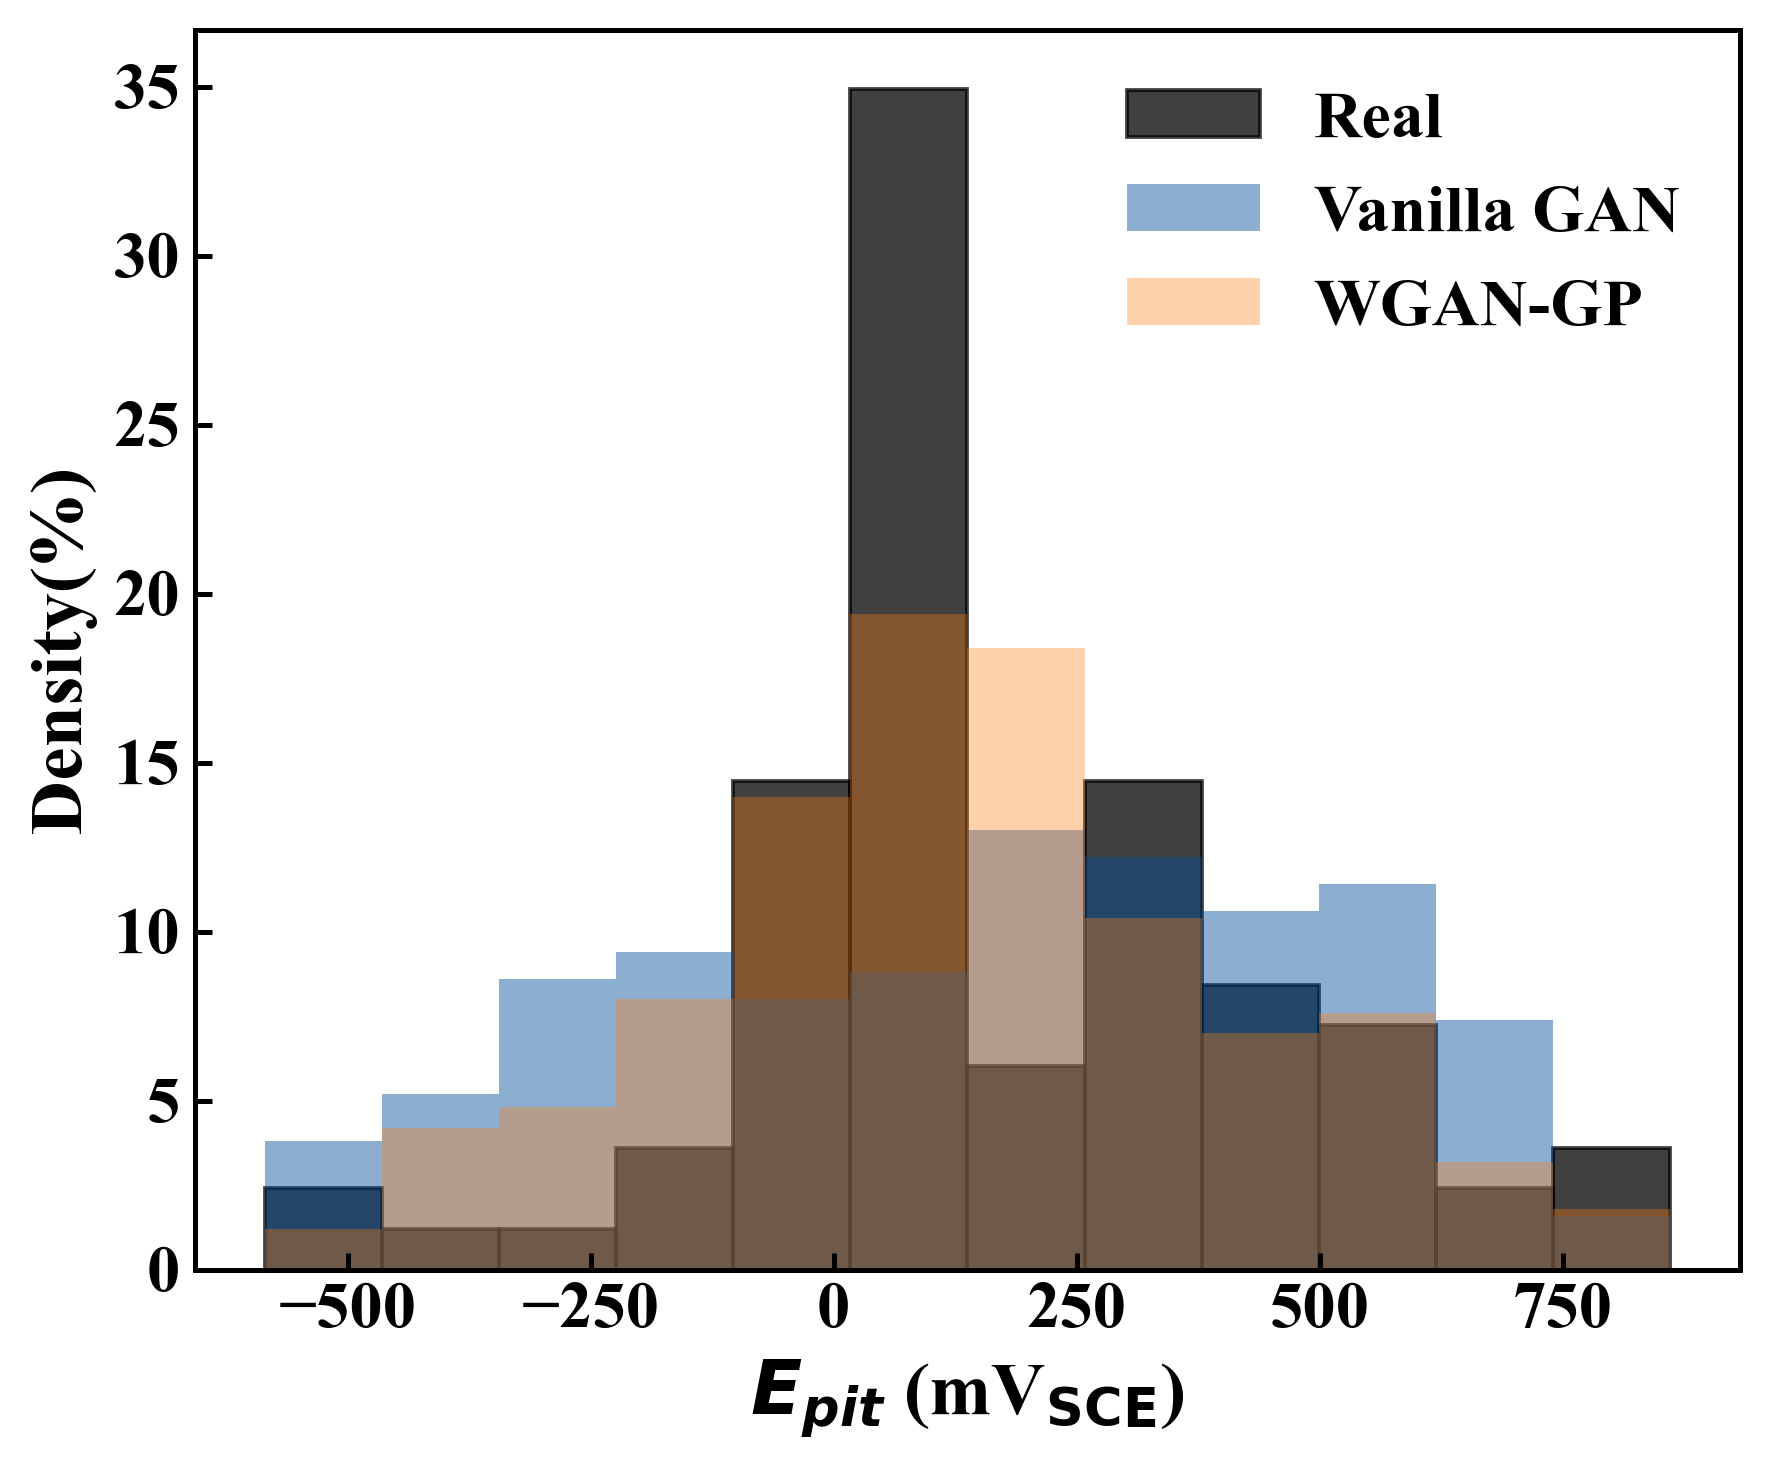

=== Wasserstein distance in 1D label space (Real vs. Method) ===
Interpolation       : 52.5515
Random noise        : 36.2827
Vanilla GAN         : 108.9238
WGAN-GP             : 49.0341


{'Interpolation': 52.5514527699459,
 'Random noise': 36.282675813720886,
 'Vanilla GAN': 108.92378277112202,
 'WGAN-GP': 49.034075199446036}

In [58]:
compare_target_distribution_four(
    y_real=y_real,
    y_interp=y_interp,
    y_noise=y_noise,
    y_gan=y_gan,
    y_wgan=y_wgan,
    nbins=12,
)
# Wasserstein distance 小 → 两个分布很接近
# Wasserstein distance 大 → 两个分布偏得很远

In [ ]:
def plot_violin_real_gan_wgan(df_real, df_gan, df_wgan, element_cols,
                              figsize=(10, 5)):
    df_real_plot = df_real[element_cols].copy()
    df_real_plot["Source"] = "Real"

    df_gan_plot = df_gan[element_cols].copy()
    df_gan_plot["Source"] = "Vanilla GAN"

    df_wgan_plot = df_wgan[element_cols].copy()
    df_wgan_plot["Source"] = "WGAN-GP"

    df_all = pd.concat([df_real_plot, df_gan_plot, df_wgan_plot], axis=0)
    df_melted = df_all.melt(
        id_vars="Source",
        value_vars=element_cols,
        var_name="Element",
        value_name="Content"
    )
    plt.rcParams.update({
        "font.family": "Times New Roman",
        "axes.linewidth": 1.2
    })

    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    sns.violinplot(
        data=df_melted,
        x="Element",
        y="Content",
        hue="Source",
        palette=["#2F7F2F", "#1F4E99", "#FF8C1A"],   
        cut=0,
        linewidth=1,
        ax=ax
    )

    ax.set_xlabel("Element", fontsize=18, fontweight="bold")
    ax.set_ylabel("Content", fontsize=18, fontweight="bold")
    ax.tick_params(axis="both", labelsize=16, width=1.2, direction="in", length=4)
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontname("Times New Roman")
        tick.set_fontweight("bold")

    leg = ax.legend(frameon=False, fontsize=16, title=None)
    for text in leg.get_texts():
        text.set_fontname("Times New Roman")
        text.set_fontweight("bold")

    plt.tight_layout()
    plt.show()

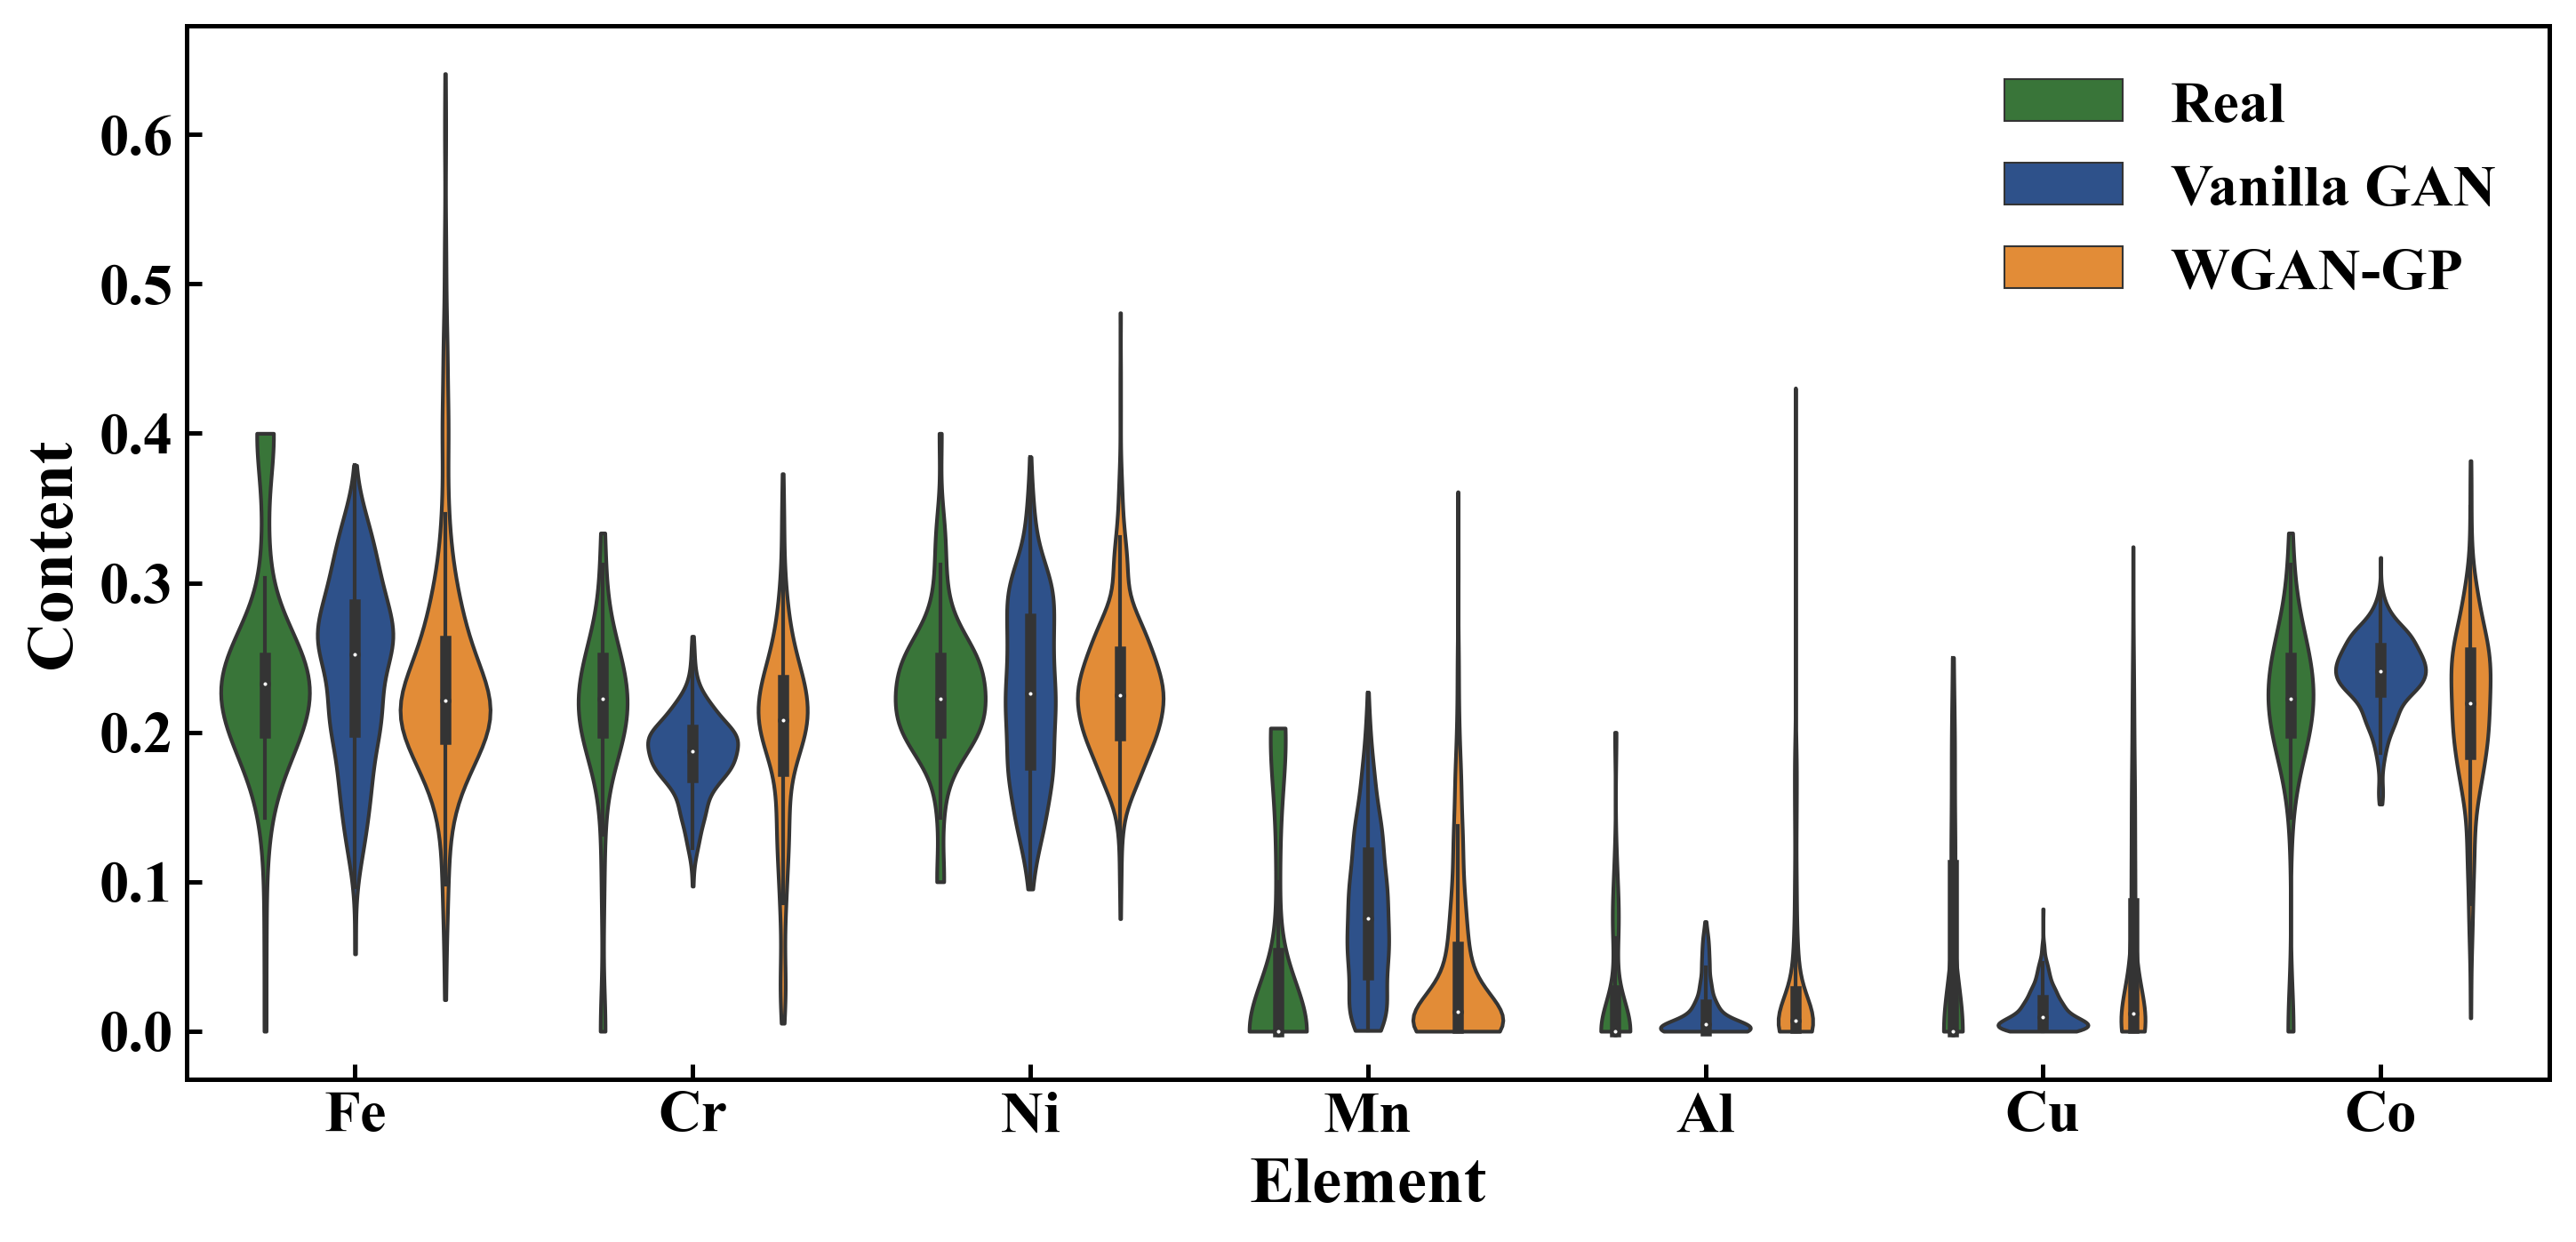

In [76]:
plot_violin_real_gan_wgan(
    df_real=df,
    df_gan=gan_new_df,
    df_wgan=wgan_new_df,
    element_cols=COMP_COLS
)

## MMD

In [28]:
from sklearn.metrics.pairwise import rbf_kernel
def mmd_rbf(X, Y, sigma=None):
    X = np.asarray(X, dtype=np.float32)
    Y = np.asarray(Y, dtype=np.float32)

    n = min(len(X), len(Y))
    if len(X) > n:
        idx = np.random.choice(len(X), n, replace=False)
        X = X[idx]
    if len(Y) > n:
        idx = np.random.choice(len(Y), n, replace=False)
        Y = Y[idx]

    Z = np.vstack([X, Y])
    if sigma is None:
        dists = np.sum((Z[:, None, :] - Z[None, :, :])**2, axis=-1)
        median_sq = np.median(dists[dists > 0])
        sigma = np.sqrt(median_sq / 2.0) if median_sq > 0 else 1.0

    gamma = 1.0 / (2.0 * sigma * sigma)

    Kxx = rbf_kernel(X, X, gamma=gamma)
    Kyy = rbf_kernel(Y, Y, gamma=gamma)
    Kxy = rbf_kernel(X, Y, gamma=gamma)

    mmd2 = Kxx.mean() + Kyy.mean() - 2.0 * Kxy.mean()
    mmd2 = max(mmd2, 0.0)
    return np.sqrt(mmd2)

In [29]:
def mmd_four_models(X_real, X_interp, X_noise, X_gan, X_wgan,
                    sigma=None):
    methods = {
        "Interpolation": X_interp,
        "Random noise": X_noise,
        "Vanilla GAN": X_gan,
        "WGAN-GP": X_wgan
    }

    results = {}
    for name, X_gen in methods.items():
        d = mmd_rbf(X_real, X_gen, sigma=sigma)
        results[name] = d
        print(f"{name:15s} MMD = {d:.4f}")
    return results


In [30]:
mmd_results = mmd_four_models(df, interp_new_df, noise_new_df, gan_new_df, wgan_new_df)

Interpolation   MMD = 0.1484
Random noise    MMD = 0.0801
Vanilla GAN     MMD = 0.3855
WGAN-GP         MMD = 0.0943


## KSD

In [31]:
import numpy as np
from sklearn.covariance import EmpiricalCovariance

def median_heuristic(Z):
    dists = np.sum((Z[:, None, :] - Z[None, :, :])**2, axis=-1)
    dists = dists[dists > 0]
    if len(dists) == 0:
        return 1.0
    median_sq = np.median(dists)
    return np.sqrt(median_sq / 2.0)

def rbf_stein_kernel(x, y, score_x, score_y, h):
    diff = x - y
    sq_norm = np.sum(diff**2)
    k = np.exp(-sq_norm / (2 * h * h))
    grad_x_k = -k * diff / (h**2)
    grad_y_k = -grad_x_k
    d = x.shape[0]
    trace_term = k * ((sq_norm / (h**4)) - d / (h**2))
    return (
        np.dot(score_x, score_y) * k +
        np.dot(score_x, grad_y_k) +
        np.dot(score_y, grad_x_k) +
        trace_term
    )

def ksd_rbf_gaussian_ref(df_real, df_gen, max_samples=400):
    X_ref = df_real.values.astype(np.float64)
    X_gen = df_gen.values.astype(np.float64)

    n = min(len(X_ref), len(X_gen), max_samples)
    X_ref = X_ref[np.random.choice(len(X_ref), n, replace=False)]
    X_gen = X_gen[np.random.choice(len(X_gen), n, replace=False)]

    mu = X_ref.mean(axis=0)
    cov = EmpiricalCovariance().fit(X_ref)
    Sigma_inv = cov.precision_

    def score_fn(x):
        return -Sigma_inv.dot(x - mu)

    Z = np.vstack([X_ref, X_gen])
    h = median_heuristic(Z)

    m = X_gen.shape[0]
    stein_matrix = np.zeros((m, m))

    for i in range(m):
        xi = X_gen[i]
        score_xi = score_fn(xi)
        for j in range(m):
            xj = X_gen[j]
            score_xj = score_fn(xj)
            stein_matrix[i, j] = rbf_stein_kernel(xi, xj, score_xi, score_xj, h)

    ksd2 = stein_matrix.mean()
    return np.sqrt(max(ksd2, 0.0))

def ksd_four(df, interp_new_df, noise_new_df, gan_new_df, wgan_new_df):
    results = {}
    results["Interpolation"] = ksd_rbf_gaussian_ref(df, interp_new_df)
    results["Random noise"]  = ksd_rbf_gaussian_ref(df, noise_new_df)
    results["Vanilla GAN"]   = ksd_rbf_gaussian_ref(df, gan_new_df)
    results["WGAN-GP"]       = ksd_rbf_gaussian_ref(df, wgan_new_df)

    print("=== Kernel Stein Discrepancy (KSD) ===")
    for name, v in results.items():
        print(f"{name:15s}: {v:.6f}")
    return results


In [32]:
def scale_all_dfs(df, interp_new_df, noise_new_df, gan_new_df, wgan_new_df):
    scaler = StandardScaler()
    scaler.fit(df)
    df_s      = pd.DataFrame(scaler.transform(df),      columns=df.columns)
    interp_s  = pd.DataFrame(scaler.transform(interp_new_df), columns=df.columns)
    noise_s   = pd.DataFrame(scaler.transform(noise_new_df),  columns=df.columns)
    gan_s     = pd.DataFrame(scaler.transform(gan_new_df),    columns=df.columns)
    wgan_s    = pd.DataFrame(scaler.transform(wgan_new_df),   columns=df.columns)
    return df_s, interp_s, noise_s, gan_s, wgan_s

In [33]:
df_s, interp_s, noise_s, gan_s, wgan_s = scale_all_dfs(
    df,
    interp_new_df,
    noise_new_df,
    gan_new_df,
    wgan_new_df
)

In [34]:
ksd_results = ksd_four(
    df_s,
    interp_s,
    noise_s,
    gan_s,
    wgan_s
)

=== Kernel Stein Discrepancy (KSD) ===
Interpolation  : 8.800010
Random noise   : 62.979264
Vanilla GAN    : 1629.612867
WGAN-GP        : 140.131337


## Classifier-Free Two-Sample Test（CF-TST）

In [35]:
from sklearn.linear_model import LogisticRegression
def cftst_score_from_df(df_real, df_gen, target_col,
                        test_size=0.3, random_state=42):
    X_real = df_real.drop(target_col, axis=1).values.astype(np.float32)
    X_gen  = df_gen.drop(target_col, axis=1).values.astype(np.float32)

    y_real = np.zeros(len(X_real))
    y_gen  = np.ones(len(X_gen))

    X = np.vstack([X_real, X_gen])
    y = np.hstack([y_real, y_gen])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True, random_state=random_state
    )

    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

def cftst_four_models(df, interp_new_df, noise_new_df, gan_new_df, wgan_new_df, target_col):
    results = {}
    results["Interpolation"] = cftst_score_from_df(df, interp_new_df, target_col)
    results["Random noise"]  = cftst_score_from_df(df, noise_new_df,  target_col)
    results["Vanilla GAN"]   = cftst_score_from_df(df, gan_new_df,    target_col)
    results["WGAN-GP"]       = cftst_score_from_df(df, wgan_new_df,   target_col)

    print("=== Classifier-Free Two-Sample Test (CF-TST, LogisticRegression) ===")
    for name, acc in results.items():
        print(f"{name:15s}: {acc:.4f}")
    return results

In [36]:
cf_tst_results = cftst_four_models(
    df_s,
    interp_s,
    noise_s,
    gan_s,
    wgan_s,
    target_col=TARGET_COL
)

=== Classifier-Free Two-Sample Test (CF-TST, LogisticRegression) ===
Interpolation  : 0.8343
Random noise   : 0.8343
Vanilla GAN    : 1.0000
WGAN-GP        : 0.8400
